# Imports

In [10]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np

import json

from transformers import MarianTokenizer
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import defaultdict

In [2]:
src_lang = "en"
translator = "opus-mt"

# Defining plot styles

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kde, gaussian_kde
import matplotlib
from matplotlib import rc

import pandas as pd

In [5]:


plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.usetex'] = True
plt.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18


# Load / Process Data

In [7]:
RECALL=-3
PRECISION=-1

TRANSLATOR="opus-mt"
SRC_LANG="en"

In [8]:
def load_old_tokens_dict(tokens_file):
    with open(tokens_file, "r") as f:
        tokens_str = (f.readlines())[0]
    tokens_str = tokens_str.replace("'", "\"")
    tokens_dict = json.loads(tokens_str)
    
    if 'worker' in tokens_dict:
        tokens_dict.pop('worker')
        
    return tokens_dict


def create_tokens_dict(variants_file, translator, src_lang, tgt_lang):
    tokens_dict = defaultdict(dict)
    tokenizer = MarianTokenizer.from_pretrained(f"Helsinki-NLP/{translator}-{src_lang}-{tgt_lang}")
    
    with open(variants_file, 'r') as var_json:
        variants_dict = json.load(var_json)
    
    for prof_gender, variants in variants_dict.items():
        prof, gender = prof_gender.split('-')
        gender = gender.capitalize()
        for v_idx, var in enumerate(variants):
            with tokenizer.as_target_tokenizer():
                tokenized = tokenizer(var)
                num_tokens = len(tokenized['input_ids']) - 1
            
            tokens_dict[f"{prof}-{str(v_idx)}"][gender] = num_tokens
    return tokens_dict


In [11]:
tokens_dict_he = create_tokens_dict("../data/wino_mt/he_variants.json",TRANSLATOR, SRC_LANG, "he")
tokens_dict_de = create_tokens_dict("../data/wino_mt/de_variants.json",TRANSLATOR, SRC_LANG, "de")

In [120]:
with open("../data/male_stereotype","r") as f:
    male_stereotype = f.readlines()
    male_stereotype = {i.strip().lower() for i in male_stereotype}

In [121]:
male_stereotype

{'analyst',
 'carpenter',
 'ceo',
 'chief',
 'construction worker',
 'cook',
 'developer',
 'driver',
 'farmer',
 'guard',
 'janitor',
 'laborer',
 'lawyer',
 'manager',
 'mechanic',
 'mover',
 'physician',
 'salesperson',
 'sheriff',
 'supervisor'}

# Create Plots

In [161]:
def graph_5_delta_g(results_file,tokens_dict,lang):
    with open(results_file, "r") as f:
        lines = f.readlines()
        recalls_str = lines[RECALL]
        recalls_str = recalls_str.replace("'", "\"")
        recalls_dict = json.loads(recalls_str)

        precisions_str = lines[PRECISION]
        precisions_str = precisions_str.replace("'", "\"")
        precisions_dict = json.loads(precisions_str)

    professions = list(tokens_dict.keys())
    delta_t_dict = dict()
    
    for p in professions:
        delta_t_dict[p] = tokens_dict[p]['Male'] - tokens_dict[p]['Female']
    delta_t_dict = dict(sorted(delta_t_dict.items(), key=lambda item: item[1]))


    x = []
    y = []
    
    data = pd.DataFrame({"Delta T": [], "Delta G": []})

    for prof, delta_t in delta_t_dict.items():
        prof = prof.lower()
        if prof in recalls_dict and prof in precisions_dict:
            r_m,r_f=recalls_dict[prof]['male_recall'],recalls_dict[prof]['female_recall']
            p_m,p_f=precisions_dict[prof]['male_precision'],precisions_dict[prof]['female_precision']
            if r_m ==0 and p_m == 0:
                male_f1 = 0
            else:
                male_f1= 2 * (r_m*p_m)/(r_m+p_m)
    
            if r_f ==0 and p_f == 0:
                female_f1 = 0
            else:
                female_f1= 2 * (r_f*p_f)/(r_f+p_f)
                
            data = data.append({"Delta T": delta_t, "Delta G": male_f1 - female_f1}, ignore_index=True)


    f, ax = plt.subplots(figsize=(7, 6))

    sns.boxplot(
        data=data, x="Delta T", y="Delta G",
        orient="v",
        notch=False, showcaps=False, showmeans=True,
        boxprops={"facecolor": (.4, .6, .8, .5)},
        medianprops={"color": "coral"})
    sns.stripplot(x="Delta T", y="Delta G", data=data,
              size=4, color=".3", linewidth=0)
    
#     z = np.polyfit(data['Delta T'], data['Delta G'], 1)
#     p = np.poly1d(z)
#     ax.plot(data['Delta T'] + len(data['Delta T'].unique())- 1, p(data['Delta T']), "r--")

    # Tweak the visual presentation
    ax.yaxis.grid(True)
    sns.despine(trim=False)
    
    plt.tight_layout()
    plt.savefig(f'../graphs/graph_5_{lang}_delta_g.pdf')
    plt.show()
    
    print("correlation")
    print(data.corr())


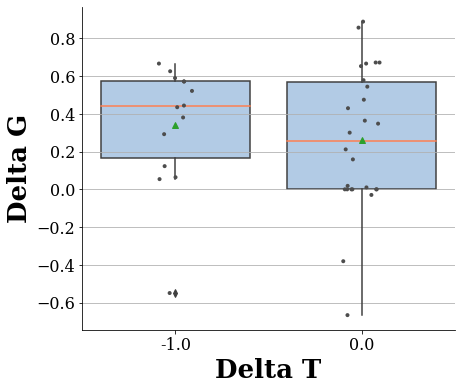

correlation
          Delta T   Delta G
Delta T  1.000000 -0.109746
Delta G -0.109746  1.000000


In [162]:
graph_5_delta_g("../data/he_results.txt", tokens_dict_he,"Hebrew")

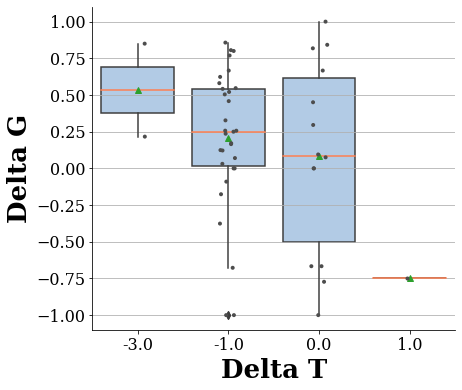

correlation
          Delta T   Delta G
Delta T  1.000000 -0.249129
Delta G -0.249129  1.000000


In [163]:
graph_5_delta_g("../data/de_results.txt", tokens_dict_de,"German")

In [164]:
def graph_5_delta_s(results_file,tokens_dict,lang, male_stereotype):
    with open(results_file, "r") as f:
        lines = f.readlines()
        recalls_str = lines[RECALL]
        recalls_str = recalls_str.replace("'", "\"")
        recalls_dict = json.loads(recalls_str)

        precisions_str = lines[PRECISION]
        precisions_str = precisions_str.replace("'", "\"")
        precisions_dict = json.loads(precisions_str)

    professions = list(tokens_dict.keys())
    delta_t_dict = dict()
    
    for p in professions:
        if p.split('-')[0] in male_stereotype:
            delta_t_dict[p] = tokens_dict[p]['Male'] - tokens_dict[p]['Female']
        else:
            delta_t_dict[p] = tokens_dict[p]['Female'] - tokens_dict[p]['Male']
    delta_t_dict = dict(sorted(delta_t_dict.items(), key=lambda item: item[1]))



    data = pd.DataFrame({"Delta T": [], "Delta S": []})

    for prof, delta_t in delta_t_dict.items():
        prof = prof.lower()
        if prof in recalls_dict and prof in precisions_dict:
            r_m,r_f=recalls_dict[prof]['male_recall'],recalls_dict[prof]['female_recall']
            p_m,p_f=precisions_dict[prof]['male_precision'],precisions_dict[prof]['female_precision']
            if r_m ==0 and p_m == 0:
                male_f1 = 0
            else:
                male_f1= 2 * (r_m*p_m)/(r_m+p_m)
    
            if r_f ==0 and p_f == 0:
                female_f1 = 0
            else:
                female_f1= 2 * (r_f*p_f)/(r_f+p_f)
            
            if prof.split('-')[0] in male_stereotype:
                
                data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1}, ignore_index=True)
            else:
                data = data.append({"Delta T": delta_t, "Delta S": female_f1 - male_f1}, ignore_index=True)


    f, ax = plt.subplots(figsize=(7, 6))

    sns.boxplot(
        data=data, x="Delta T", y="Delta S",
        orient="v",
        notch=False, showcaps=False,showmeans=True,
        boxprops={"facecolor": (.6, .8, .4, .5)},
        medianprops={"color": "coral"})
    sns.stripplot(x="Delta T", y="Delta S", data=data,
              size=4, color=".3", linewidth=0)
    
#     z = np.polyfit(data['Delta T'], data['Delta G'], 1)
#     p = np.poly1d(z)
#     ax.plot(data['Delta T'] + len(data['Delta T'].unique())- 1, p(data['Delta T']), "r--")

    # Tweak the visual presentation
    ax.yaxis.grid(True)
    sns.despine(trim=False)
    
    plt.tight_layout()
    plt.savefig(f'../graphs/graph_5_{lang}_delta_s.pdf')
    plt.show()
    
    print("correlation")
    print(data.corr())
    


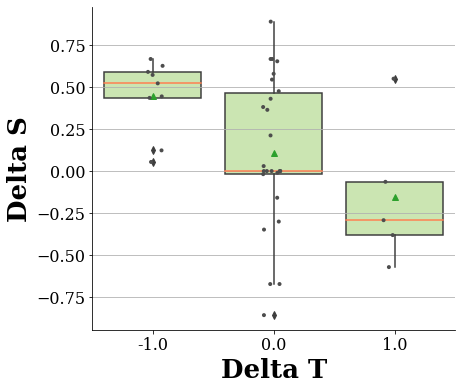

correlation
          Delta T   Delta S
Delta T  1.000000 -0.414946
Delta S -0.414946  1.000000


In [167]:
graph_5_delta_s("../data/he_results.txt", tokens_dict_he,"Hebrew", male_stereotype)

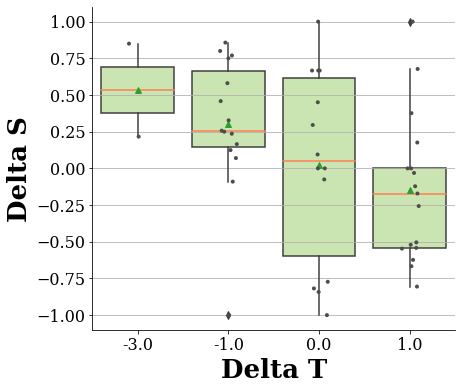

correlation
          Delta T   Delta S
Delta T  1.000000 -0.368684
Delta S -0.368684  1.000000


In [166]:
graph_5_delta_s("../data/de_results.txt", tokens_dict_de,"German", male_stereotype)